# Assignment 3 - Tensorflow

Implementing a Linear Classifier for polarity movie reviews.

See course homepage: http://stp.lingfil.uu.se/~nivre/master/ml.html

See assignment: http://stp.lingfil.uu.se/~shaooyan/ml18/Assignment3.pdf 

## Imports

In [73]:
import pandas as pd
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

import util
import collections
import time

## Prepare Dataset

In [72]:
# Type of features to use. This can be set to 'bigram' or 'unigram+bigram'
# to use bigram features instead of or in addition to unigram features.
# Not required for assignment.
feature_type = 'unigram'

data = util.load_movie_data('poldata.zip')

data.select_feature_type(feature_type)

# Split the data set randomly into training, validation and test sets.
training_data, val_data, test_data = data.train_val_test_split()

nfeatures = len(training_data.vocabulary)

# Convert the sparse indices into dense vectors
ds_training = util.sparse_to_dense(training_data, nfeatures)
ds_val = util.sparse_to_dense(val_data, nfeatures)
ds_test = util.sparse_to_dense(test_data, nfeatures)

print("Number of features: %s" % nfeatures)

Number of features: 50920


## Convert to sparse data

It is a bit pointless to first create the dense data and then transform it into sparse data,
however I didn't want to mess with the internal data structures.

See https://www.tensorflow.org/api_docs/python/tf/SparseTensor for a documentation (SparseTensorValue is should be used outside of a Graph context). In the graph, a `sparse_placeholder` has to be used, as well as the `sparse_tensor_dense_matmul` instead of `matmul` to multiply the weights and the features (https://www.tensorflow.org/api_docs/python/tf/sparse_tensor_dense_matmul).

In [66]:
def generate_indices(dense_matrix):
    for r_i, row in enumerate(dense_matrix):
        for c_i in np.nditer(np.where(row == 1)):
            yield r_i, int(c_i)

def dense_to_sparse(dense_matrix):            
    np_matrix = np.asarray(dense_matrix)
    indices = list(generate_indices(np_matrix))
    values = [1 for _ in indices]
    
    return tf.SparseTensorValue(indices, values, np_matrix.shape)

sp_training = dense_to_sparse(ds_training)
sp_test = dense_to_sparse(ds_test)
sp_val = dense_to_sparse(ds_val)

## Loss Functions (Task 7)

In [5]:
def logistic_loss(y, pred):
    y = tf.cast(y, tf.float32)
    pred = tf.cast(pred, tf.float32)
    return tf.reduce_mean(tf.log(1.0 + tf.exp(-y*pred)))

def hinge_loss(y, pred):
    y = tf.cast(y, tf.float32)
    pred = tf.cast(pred, tf.float32)
    return tf.losses.hinge_loss(y, pred)

def mse_loss(y, pred):
    y = tf.cast(y, tf.float32)
    pred = tf.cast(pred, tf.float32)
    return tf.losses.mean_squared_error(y, pred)

## Hyperparameters

In [6]:
# Regularisation strength
reg_lambda = 0.001

# Learning rate
learning_rate = 0.001

# Number of training iterations
niterations = 15

# Loss function to use
loss_function = mse_loss
loss_function_name = "mse_loss"

# Type of regularisation to use (select one and comment out the other)
regulariser = tf.contrib.layers.l2_regularizer(reg_lambda)
# regulariser = tf.contrib.layers.l1_regularizer(reg_lambda)
regulariser_name = "l2"

# This should only be enabled once you've decided on a final set
# of hyperparameters
enable_test_set_scoring = False

## Building the Computational Graph

In [64]:
graph = tf.Graph()

with graph.as_default():
    with tf.variable_scope('classifier'):

        # Define the placeholder where we feed in the data
        features = tf.sparse_placeholder(tf.int32, [None, nfeatures],
                                         name='input_placeholder')

        labels = tf.placeholder(tf.float16, [None], name='labels_placeholder')
        
        # Variables are what we try to estimate!
        # Define the weights of the classifier
        weights = tf.get_variable('weights', [nfeatures],
                                  initializer=tf.zeros_initializer())
        
        # The bias is a scalar
        bias = tf.get_variable('bias', [],
                               initializer=tf.zeros_initializer())

        # Two tensors must have same dtype and compatible shape for dot product
        features = tf.cast(features, tf.float32)
        
        exp_weights = tf.reshape(weights, [nfeatures, 1])

        # Compute dot product
        logits = tf.sparse_tensor_dense_matmul(features, exp_weights)
        
        logits = tf.add(logits, bias) # TODO Is this correct?
        
        # Reshape the result to a vector to remove the dimension
        # added to `exp_weights`.
        logits = tf.reshape(logits, [-1])
        # Define loss

        loss_ureg = loss_function(labels, logits)

        # Regularisation
        loss_reg = regulariser(weights)
        loss = loss_ureg + loss_reg

        # Configuerate gradient descent
        config = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

        # Initialiser
        init = tf.global_variables_initializer()

graph.finalize()

## Training

In [74]:
# Define a training session and train the classifier
sess = tf.Session(graph=graph)
writer = tf.summary.FileWriter("output", sess.graph)

def predict(input_features):
    """Applies the classifier to the data and returns a list of predicted labels."""
    predictions = []
    pred = sess.run(logits, feed_dict={features: input_features})
    for x in pred:
        if x > 0:
            predictions.append(1.0)
        else:
            predictions.append(-1.0)
    return predictions

def accuracy(gold, hypothesis):
    """Computes an accuracy score given two vectors of labels."""
    assert len(gold) == len(hypothesis)
    return sum(g == h for g, h in zip(gold, hypothesis)) / len(gold)

# Before starting, initialize the variables. We will 'run' this first.
sess.run(init)
training_log = []

# Training iterations
print("Run %s iterations..." % niterations)

stats = {
    "training_loss_reg": [],
    "training_loss_unreg": [],
    "training_acc": [],
    "val_loss": [],
    "val_acc": []
}

training_log = []
for i in range(niterations):
    _, t_loss_unreg, t_loss_reg = sess.run(
        [config, loss_ureg, loss],
        feed_dict={features: sp_training, labels: training_data.labels})

    v_loss = sess.run(loss, feed_dict={features: sp_val, labels:val_data.labels})

    training_predictions = predict(sp_training)
    training_accuracy = accuracy(training_data.labels, training_predictions)

    val_predictions = predict(sp_val)
    val_accuracy = accuracy(val_data.labels, val_predictions)
    
    # Build statistics for pandas
    stats['training_loss_reg'].append(t_loss_reg)
    stats['training_loss_unreg'].append(t_loss_unreg)
    stats['training_acc'].append(training_accuracy)
    stats['val_loss'].append(v_loss)
    stats['val_acc'].append(val_accuracy)
    
    # Collect statistics for the internal tool thing
    log_record = collections.OrderedDict()
    log_record['training_loss_reg'] = t_loss_unreg
    log_record['training_loss_unreg'] = t_loss_reg
    log_record['training_acc'] = training_accuracy
    log_record['val_loss'] = v_loss
    log_record['val_acc'] = val_accuracy

    training_log.append(log_record)

    # Display info on training progress
    util.display_log_record(i, log_record)

print('Training completed.')

Run 15 iterations...
Iteration 0: training_loss_reg 1, training_loss_unreg 1, training_acc 0.6025, val_loss 0.998286, val_acc 0.555
Iteration 1: training_loss_reg 0.997696, training_loss_unreg 0.997696, training_acc 0.635625, val_loss 0.996574, val_acc 0.585
Iteration 2: training_loss_reg 0.995413, training_loss_unreg 0.995413, training_acc 0.660625, val_loss 0.994863, val_acc 0.6
Iteration 3: training_loss_reg 0.993149, training_loss_unreg 0.993149, training_acc 0.686875, val_loss 0.993153, val_acc 0.635
Iteration 4: training_loss_reg 0.990899, training_loss_unreg 0.990899, training_acc 0.70875, val_loss 0.991445, val_acc 0.65
Iteration 5: training_loss_reg 0.988662, training_loss_unreg 0.988662, training_acc 0.730625, val_loss 0.989739, val_acc 0.665
Iteration 6: training_loss_reg 0.986436, training_loss_unreg 0.986436, training_acc 0.754375, val_loss 0.988035, val_acc 0.7
Iteration 7: training_loss_reg 0.984222, training_loss_unreg 0.984222, training_acc 0.76875, val_loss 0.986333, 

,training_acc,training_loss_reg,training_loss_unreg,val_acc,val_loss
0,0.602500,1.000000,1.000000,0.555,0.998286
1,0.635625,0.997696,0.997696,0.585,0.996574
2,0.660625,0.995413,0.995413,0.600,0.994863
3,0.686875,0.993149,0.993149,0.635,0.993153
4,0.708750,0.990899,0.990899,0.650,0.991445
5,0.730625,0.988662,0.988662,0.665,0.989739
6,0.754375,0.986436,0.986436,0.700,0.988035
7,0.768750,0.984222,0.984222,0.715,0.986333
8,0.783125,0.982017,0.982017,0.710,0.984635
9,0.796875,0.979823,0.979823,0.720,0.982941


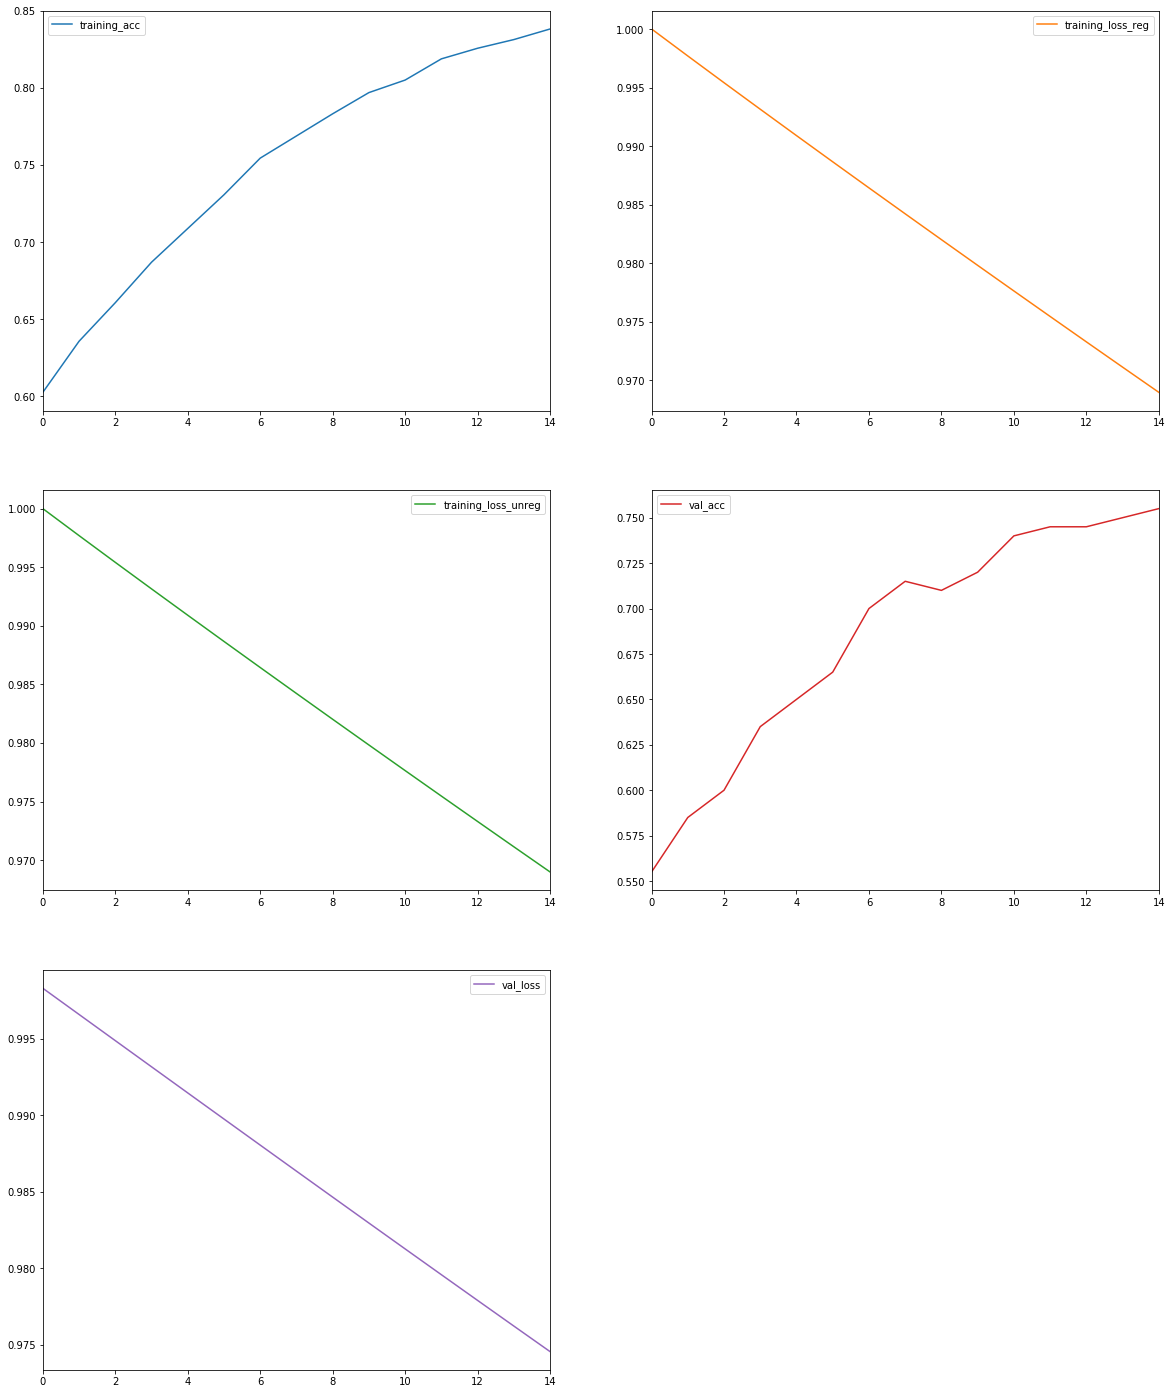

In [75]:
df = pd.DataFrame.from_dict(stats)

df.plot(subplots=True, layout=(-1, 2), figsize=(20, 25), sharex=False, sharey=False)

plt.savefig('graphs_%s.pdf' % time.time())

df

## Evaluation

In [76]:
print('=====================')
print('MODEL CHARACTERISTICS')
print('=====================')
print()

# Display some useful statistics about the model and the training process.
title = 'Data set: %s - Regulariser: %g - Learning rate: %g' % (data.name, reg_lambda, learning_rate)

print()

final_weights = sess.run(weights)
final_bias = sess.run(bias)
util.show_stats(title, training_log, final_weights, final_bias, data.vocabulary,
                top_n=1, write_to_file="results.csv", configuration={
                    'reg_lambda': reg_lambda,
                    'learning_rate': learning_rate,
                    'loss_function': loss_function_name,
                    'regulariser': regulariser_name,
                    'niterations': niterations,
                    'val_accuracy': val_accuracy
                })


# util.create_plots(title, training_log, weights, log_keys=['training_loss_reg', 'val_loss'])

if enable_test_set_scoring:
    # Check the performance on the test set.
    test_loss = sess.run(loss, feed_dict={features: ds_test, labels:test_data.labels})
    test_predictions = predict(ds_test)
    test_accuracy = accuracy(test_data.labels, test_predictions)

    print()
    print('====================')
    print('TEST SET PERFORMANCE')
    print('====================')
    print()
    print('Test loss: %g' % test_loss)
    print('Test accuracy: %g' % test_accuracy)
    

MODEL CHARACTERISTICS


Data set: Movie reviews - Regulariser: 0.001 - Learning rate: 0.001

Best regularised training loss: 0.968984
Final regularised training loss: 0.968984
Best validation loss: 0.974539
Final validation loss: 0.974539

Number of weights: 50920
Bias: -5.70449e-05
Number of weights with magnitude > 0.01: 0

Top 1 positive features:
0.00219916	life

Top 1 negative features:
-0.00388995	bad


## Task 6

Run with standard parameters.

Top 10 positive words:

1. life
2. also
3. best
4. world
5. many
6. both
7. perfect
8. performances
9. very
10. great

Top 10 negative words:
bad
1. worst
2. plot
3. stupid
4. ?
5. boring
6. script
7. nothing
8. why
9. least
10. !